In [15]:
import os
os.environ["OMP_NUM_THREADS"] = "3"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.optimize import minimize

from joblib import Parallel, delayed

data_path="E:\\5 Code\\2025_cu_qmim\\data" #修改为data存储路径

metric_data=os.path.join(data_path,'price_metrics.parquet')
std_data=os.path.join(data_path,'factors_std.parquet')
px_all = pd.read_parquet(metric_data)
factors_std = pd.read_parquet(std_data)

# Extract PX_LAST only (MultiIndex columns)
px = px_all.xs("PX_LAST", axis=1, level="metric")
# Resample to month end
px_m = px.resample("M").last()

keep_metrics = [

    # VALUE
    "PE_RATIO",
    "PX_TO_BOOK_RATIO",
    "PX_TO_SALES_RATIO",
    "CURRENT_EV_TO_T12M_EBITDA",
    "FREE_CASH_FLOW_YIELD",
    "EQY_DVD_YLD_12M",

    # QUALITY
    "EBITDA_MARGIN",
    "GROSS_MARGIN",
    "OPER_MARGIN",
    "PROF_MARGIN",
    "RETURN_ON_ASSET",

    # LEVERAGE
    "TOT_DEBT_TO_EBITDA",
    "TOT_DEBT_TO_TOT_EQY",

    # SIZE
    "CURRENT_MARKET_CAP_SHARE_CLASS",

    # RISK
    "BETA_ADJ_OVERRIDABLE",
    "VOLATILITY_30D", "VOLATILITY_90D", "VOLATILITY_180D", "VOLATILITY_360D",

    # TAIL RISK
    "RET_SKEW_30D", "RET_SKEW_90D", "RET_SKEW_180D", "RET_SKEW_360D",
    "RET_KURT_30D", "RET_KURT_180D", "RET_KURT_360D", "RET_KURT_90D",

    # LIQUIDITY
    "TURNOVER","RET_30D"
]

# 1. Clean data

def _winsorize_row(row, lower,   upper):
    if row.isna().all():
        return row
    lo, hi = row.quantile([lower, upper])
    return row.clip(lo, hi)

def clean_data(df, lower= 0.01, upper = 0.99):
    
    df_w = df.apply(_winsorize_row, axis=1, args=(lower, upper))
    #zscore
    mean_cs = df_w.mean(axis=1)
    std_cs = df_w.std(axis=1).replace(0, np.nan)
    df_z=df_w.sub(mean_cs, axis=0).div(std_cs, axis=0)
    return df_z

C:\Users\25188\AppData\Local\Temp\ipykernel_80788\3693770723.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m = px.resample("M").last()


In [16]:
#find trade dates
def ewma(factors_kmeans,lambda_=0.94):
    alpha = 1 - lambda_

    metrics_in_data = factors_kmeans.columns.get_level_values("metric").unique()

    for m in metrics_in_data:
        X = factors_kmeans.xs(m, axis=1, level="metric")
        X_smooth = X.ewm(alpha=alpha, adjust=False, min_periods=1).mean()

        X_smooth.columns = pd.MultiIndex.from_product(
            [[m], X_smooth.columns], names=["metric", "stock"]
        )

        mask = factors_kmeans.columns.get_level_values("metric") == m
        factors_kmeans.loc[:, mask] = X_smooth.values
    return factors_kmeans

def get_trade_dates(px_m,factors_std,gap):
    fwd_ret_m = np.log(px_m.shift(-1)) - np.log(px_m)
    mom_6_1 = np.log(px_m.shift(1)) - np.log(px_m.shift(gap+1))
    mom6_z = clean_data(mom_6_1.shift(gap))

    factors_kmeans = factors_std.loc[:, factors_std.columns.get_level_values("metric").isin(keep_metrics)]
    factors_kmeans = factors_kmeans.ffill()
    factors_kmeans_m=ewma(factors_kmeans)

    rebalance_dates = mom6_z.dropna(how="all").index
    rebalance_dates = rebalance_dates.intersection(factors_kmeans_m.index)
    rebalance_dates = rebalance_dates.intersection(fwd_ret_m.index)

    rebalance_dates = rebalance_dates[(rebalance_dates >= "2011-01-31") ]
    return rebalance_dates,factors_kmeans_m,mom6_z,fwd_ret_m


In [17]:
def get_orig_weights(rebalance_dates,factors_kmeans_m,K):
    #compute clusters
    clusters_dict = {}
    # go through all time
    for t_idx, t in enumerate(rebalance_dates[:-1]):
        row_t = factors_kmeans_m.loc[t]
        X_t = row_t.unstack("metric") 
        
        min_valid = int(0.7 * X_t.shape[1])
        X_t = X_t.dropna(axis=0, thresh=min_valid).fillna(0)
        
        km = KMeans(n_clusters=K, n_init=50, random_state=0)
        labels = km.fit_predict(X_t.values)
        clusters_t = pd.Series(labels, index=X_t.index, name="cluster  ")
        clusters_dict[t] = clusters_t
    return clusters_dict

In [18]:
def _obj(w,mu,cov):
    ret = float(np.dot(w, mu))
    var = float(w @ cov @ w)
    if var <= 0:
        return 1e6  
    sharpe = ret / np.sqrt(var)
    return -sharpe

def _turnover_con(w, w0, tau):
    return tau - np.sum(np.abs(w - w0))

def max_sharpe_opt(mu, cov, w0, w_max=0.070, tau=0.02):
    """
    max (w^T mu / sqrt(w^T Σ w))
        1) sum w = 0
        2) |w_i| <= w_max
        3) ∑ |w_i - w0_i| <= tau
    """
    n = len(mu)
    if n == 0:
        return np.array([])
    

    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w)},
        {"type": "ineq","fun": _turnover_con,"args": (w0, tau)}
    ]
    bounds = [(-w_max, w_max)] * n
    w_init = np.clip(w0, -w_max, w_max)
    
    res = minimize(_obj,w_init,args=(mu, cov),
                   method="SLSQP",bounds=bounds,
                   constraints=cons,
                   options={"maxiter": 500, "ftol": 1e-9, "disp": False})
    return res.x

def get_optimal_weights(t,clusters_t,mom_t,price_df,
                        top_per=0.2,tail_per=0.2,lookback_months=6,
                        w_max=0.10,tau=0.10):
    w_all = pd.Series(0.0, index=clusters_t.index)
    w_all_orig = pd.Series(0.0, index=clusters_t.index)
    for cl in clusters_t.unique():
        in_cl = clusters_t[clusters_t ==cl].index
        mom_cl = mom_t.reindex(in_cl).dropna()
        len_cl=len(in_cl)
        top = mom_cl.nlargest(int(len_cl*top_per))
        bottom = mom_cl.nsmallest(int(len_cl*tail_per))
        selected = pd.Index(top.index.union(bottom.index))

        w_long =  top / top.sum()     # sum = +1
        w_short = bottom / abs(bottom.sum())  # sum = -1
        w = pd.concat([w_long, w_short])

        start = t - pd.DateOffset(months=lookback_months)
        px_win = price_df.loc[start:t, selected].dropna(how="any")

        ret_win = np.log(px_win).diff().dropna() # type: ignore
        cov = ret_win.cov()
        mu = mom_cl.reindex(selected).values
        w_opt = max_sharpe_opt(mu=mu,cov=cov,w0=w,w_max=w_max,tau=tau)

        w_opt_s = pd.Series(w_opt, index=selected)*int(len_cl )/len(clusters_t)
        w_orig=pd.Series(w, index=selected)*int(len_cl )/len(clusters_t)
        w_all.loc[selected] = w_opt_s
        w_all_orig.loc[selected] = w_orig

    return w_all,w_all_orig


In [19]:
def _one_date_weights(t, clusters, mom6_z, px):

    clusters_t = clusters.loc[t]     
    mom_t      = mom6_z.loc[t]       
    price_df   = px                  

    w_opt,w_opt_orig = get_optimal_weights(t, clusters_t, mom_t, price_df)
    w_opt.name = t 
    w_opt_orig.name = t
    return w_opt,w_opt_orig


def run_parallel_weights(rebalance_dates, clusters, mom6_z, px, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(_one_date_weights)(t, clusters, mom6_z, px)
        for t in rebalance_dates
    )

    # results: list of (w_opt, w_opt_orig)
    w_opt_list, w_opt_orig_list = zip(*results)

    weights_df = pd.DataFrame(w_opt_list)
    weights_df.index.name = "date"

    weights_orig_df = pd.DataFrame(w_opt_orig_list)
    weights_orig_df.index.name = "date"

    return weights_df, weights_orig_df

In [20]:
k=20
gap=4

rebalance_dates,factors_kmeans_m,mom6_z,fwd_ret_m=get_trade_dates(px_m,factors_std,gap)
clusters_dict=get_orig_weights(rebalance_dates,factors_kmeans_m,k)
clusters= pd.DataFrame(clusters_dict).T

weights_df, weights_orig_df = run_parallel_weights(rebalance_dates[:-1], clusters, mom6_z, px, n_jobs=8)

In [21]:
l=weights_df.abs().sum(axis=1).fillna(0)
weights_df=weights_df.div(l, axis=0)*2

l=weights_orig_df.abs().sum(axis=1).fillna(0)
weights_orig_df=weights_orig_df.div(l, axis=0)*2

weights_df.to_csv(f'weights_{k}_{gap}.csv')
weights_orig_df.to_csv(f'weights_orig_{k}_{gap}.csv')

In [38]:
diff_abs = weights_orig_df.diff(axis=0).abs().sum().sum()
diff_abs/weights_orig_df.shape[0]

np.float64(2.3074786078304137)

In [22]:
'''param_lst=[(10,2),(10,6),(5,2),(5,6),(30,2),(30,4),(60,2),(60,4)]
for k,gap in param_lst:
    rebalance_dates,factors_kmeans_m,mom6_z,fwd_ret_m=get_trade_dates(px_m,factors_std,gap)
    clusters_dict=get_orig_weights(rebalance_dates,factors_kmeans_m,k)
    clusters= pd.DataFrame(clusters_dict).T

    weights_df, weights_orig_df = run_parallel_weights(rebalance_dates[:-1], clusters, mom6_z, px, n_jobs=8)

    weights_df.to_csv(f'weights_{k}_{gap}.csv')
    weights_orig_df.to_csv(f'weights_orig_{k}_{gap}.csv')'''

"param_lst=[(10,2),(10,6),(5,2),(5,6),(30,2),(30,4),(60,2),(60,4)]\nfor k,gap in param_lst:\n    rebalance_dates,factors_kmeans_m,mom6_z,fwd_ret_m=get_trade_dates(px_m,factors_std,gap)\n    clusters_dict=get_orig_weights(rebalance_dates,factors_kmeans_m,k)\n    clusters= pd.DataFrame(clusters_dict).T\n\n    weights_df, weights_orig_df = run_parallel_weights(rebalance_dates[:-1], clusters, mom6_z, px, n_jobs=8)\n\n    weights_df.to_csv(f'weights_{k}_{gap}.csv')\n    weights_orig_df.to_csv(f'weights_orig_{k}_{gap}.csv')"

In [ ]:
def calc_ret(w_df,px):
    ret_df=px.pct_change()
    w_d = w_df.reindex(ret_df.index, method="ffill").fillna(0)
    ret=(w_d*ret_df).dropna(how='all').sum(axis=1)
    return ret
 
price_df = px.loc[(px.index >= "2012-11-30")]
ret1=calc_ret(weights_df,price_df)
ret2=calc_ret(weights_orig_df,price_df)


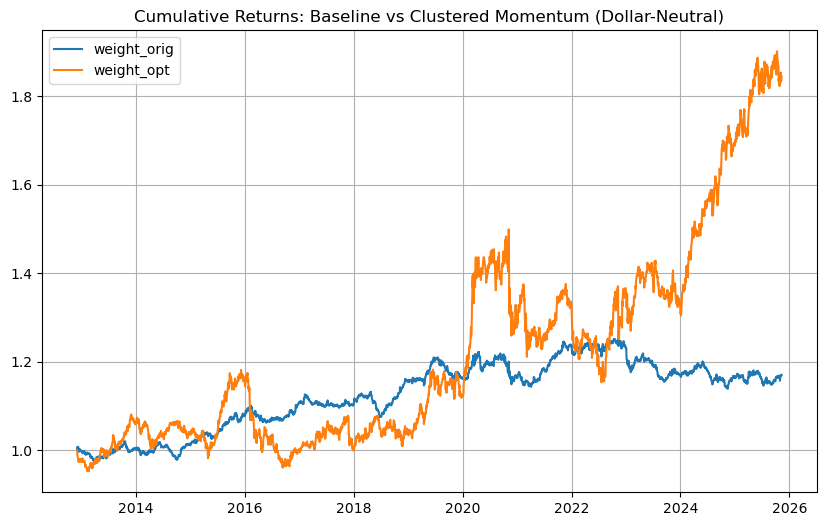

In [40]:
cum = (1 + ret1).cumprod()
cum2 = (1 + ret2).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum.index, cum, label="weight_orig")
plt.plot(cum2.index, cum2, label="weight_opt")
plt.legend()
plt.title("Cumulative Returns: Baseline vs Clustered Momentum (Dollar-Neutral)")
plt.grid(True)
plt.show()


In [42]:
df=pd.read_csv('E:\\5 Code\\2025_cu_qmim\\cluster_weights_K20.csv',index_col=0)


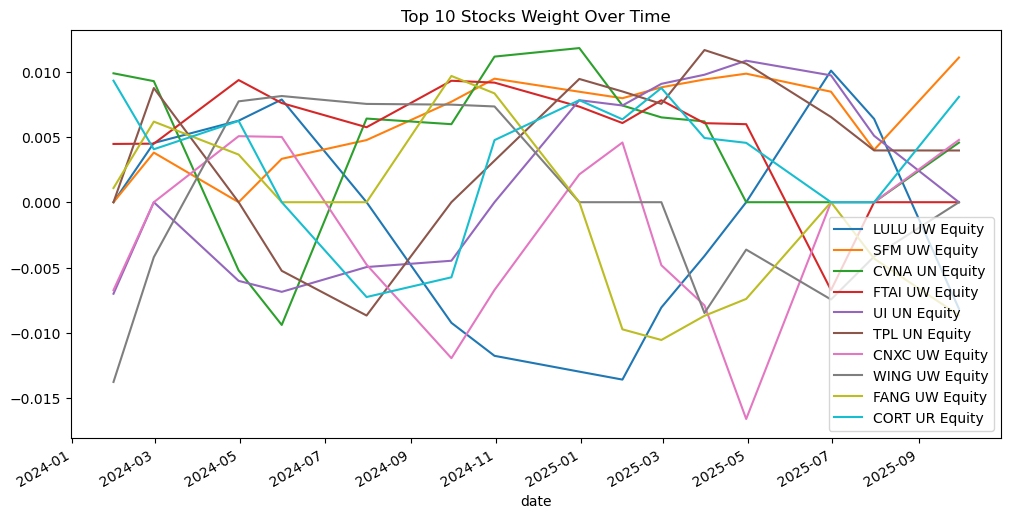

In [ ]:
test=df[-15:]
topN = test.abs().mean().sort_values(ascending=False).head(10).index
test[topN].plot(figsize=(12,6))
plt.title("Top 10 Stocks Weight Over Time")
plt.legend(loc='lower right') 
plt.show()


Top weight columns: ['LULU UW Equity', 'SFM UW Equity', 'CVNA UN Equity']


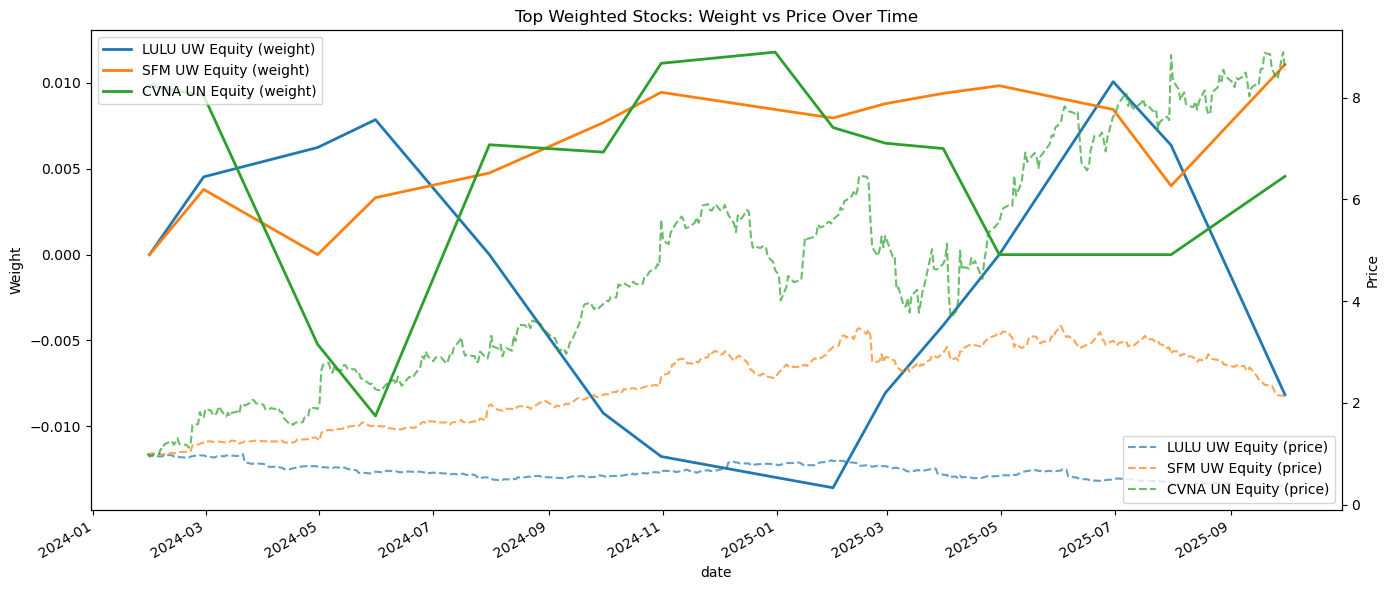

In [30]:
topN = 3                                   # 想选几个
top_cols = test.abs().mean().sort_values(ascending=False).head(topN).index.tolist()
print("Top weight columns:", top_cols)

# 2. price df 中选这些列（如果名称完全对应）
price_sub = px.loc[(px.index >= "2024-01-30")&(px.index<= "2025-09-30")]
price_sub=price_sub.div(price_sub.iloc[0])
price_sub=price_sub[top_cols]

# 3. 作图
fig, ax1 = plt.subplots(figsize=(14,6))

# --- 左轴：权重 ---
draw=test[top_cols]
draw.plot(ax=ax1, linewidth=2)
ax1.set_ylabel("Weight")
ax1.set_title("Top Weighted Stocks: Weight vs Price Over Time")

# --- 右轴：价格 ---
ax2 = ax1.twinx()
price_sub.plot(ax=ax2, linestyle='--', alpha=0.7)
ax2.set_ylabel("Price")

# 图例位置放在下方
ax1.legend([f"{c} (weight)" for c in top_cols], loc='upper left')
ax2.legend([f"{c} (price)" for c in top_cols], loc='lower right')

plt.tight_layout()
plt.show()

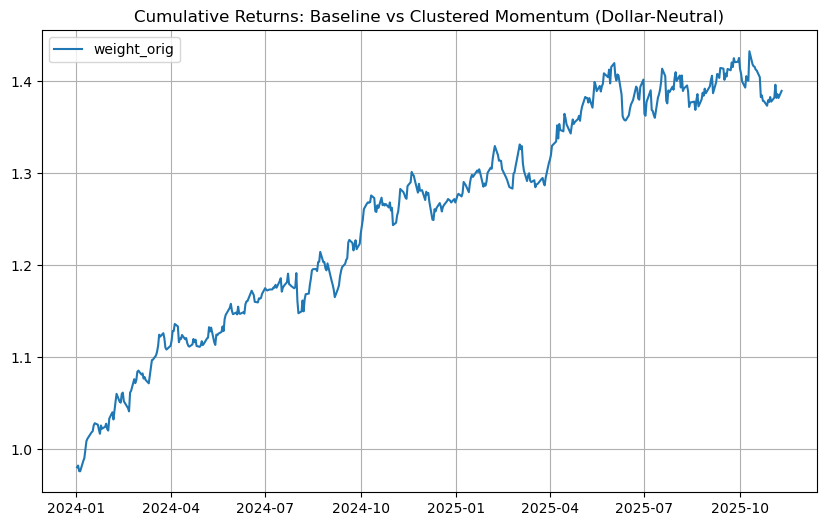

In [27]:
ret2024=ret2[-467:]
cumsum=(1+ret2024).cumprod()
plt.figure(figsize=(10, 6))
plt.plot(cumsum.index, cumsum, label="weight_orig")
plt.legend()
plt.title("Cumulative Returns: Baseline vs Clustered Momentum (Dollar-Neutral)")
plt.grid(True)
plt.show()

In [28]:
cum2 = (1 + ret2).cumprod()